In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import clear_output

import os
import random
import itertools

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [16]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [370]:
train = pd.read_csv(r"New_train.csv")
test = pd.read_csv(r"Test.csv")

sarima grid search

In [186]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M', n_configurations=5):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in tqdm(pdq):
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                                #freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'], ascending=True, ignore_index=True).head(n_configurations)
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
#sarimax_gridsearch(ts, pdq, pdqs, freq='M')

parameters_for_sarima

In [326]:
def parameters_for_sarima(ts, lags, seasonality, threshold = 0.05, mod=0):
    #если mod = 0 возвращается одна конфигурация
    #если mod = 1 возвращается множество конфигураций
    
    #Растояние на котором должна быть точка от доверительного интервала.
    #Например threshold=0.05, тогда если точка находится вне conv_interval*1.05, то она нам подходит, иначе считаем ее незначительной
    #Тем самым отбрасываются точки, которые лежат практически на границе доверительного интервале
    m = 1 + threshold
    idx = np.arange(lags+1)
    
    #Проверка стационарности
    #Стратегии дифференцирования формата [d, D]
    #diff_strategies = [[0,0],[1,0],[0,1],[1,1],[2,1],[2,2]]
    diff_strategies = [[0,0],[0,1],[0,2],[1,0],[1,2],[2,1],[2,2]]
    for st in diff_strategies:
        diff_ts = diff(ts, k_diff = st[0], k_seasonal_diff=st[1], seasonal_periods=seasonality)
        kpss_result = kpss(diff_ts)
        if kpss_result[1]>0.05: #p_value
            d=st[0]
            D=st[1]
            break
        elif st==[2,2] and kpss_result[1]<0.05:
            d,D=1,0
            print('Ряд не удалось привести к стационарному виду')
    
    #Автокорреляционная функция с интервалами, для определения порядка q
    #Интревалы преобразуем чтобы они были симметриный относительно Ох. Интервалы идентичны интервалам на acf_plot, pacf_plot.
    acf_, acf_conf = acf(ts, nlags=lags, alpha=0.05)
    acf_conf = np.array([acf_conf[:,0] - acf_, acf_conf[:,1] - acf_ ]).T
    q = idx[(acf_[idx] > acf_conf[:,1]*m) | (acf_[idx] < acf_conf[:,0]*m)]
    
    #Частная автокорреляционная функция с интервалами, для определения порядка p
    pacf_, pacf_conf = pacf(ts, nlags=lags, alpha=0.05, method='ywmle')
    pacf_conf = np.array([pacf_conf[:,0] - pacf_, pacf_conf[:,1] - pacf_ ]).T
    p = idx[(pacf_[idx] > pacf_conf[:,1]*m) | (pacf_[idx] < pacf_conf[:,0]*m)]
    
    #Сезонная автокорреляционная функция с интервалами, для определения порядка Q
    seas_decompose = seasonal_decompose(ts, period = seasonality)
    acf_seas, acf_seas_conf = acf(seas_decompose.seasonal, nlags=lags, alpha=0.05)
    acf_seas_conf = np.array([acf_seas_conf[:,0] - acf_seas, acf_seas_conf[:,1] - acf_seas ]).T
    Q = idx[(acf_seas[idx] > acf_seas_conf[:,1]*m) | (acf_seas[idx] < acf_seas_conf[:,0]*m)]
    
     #Частная сезонная автокорреляционная функция с интервалами, для определения порядка P
    pacf_seas, pacf_seas_conf = pacf(seas_decompose.seasonal, nlags=lags, alpha=0.05, method='ywmle')
    pacf_seas_conf = np.array([pacf_seas_conf[:,0] - pacf_seas, pacf_seas_conf[:,1] - pacf_seas ]).T
    P = idx[(pacf_seas[idx] > pacf_seas_conf[:,1]*m) | (pacf_seas[idx] < pacf_seas_conf[:,0]*m)]
    
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    plot_acf(ts, lags=lags, ax=axes[0,0], title='TS Autocorrelation')
    plot_pacf(ts, lags=lags, ax=axes[0,1],title='TS Partial Autocorrelation',method='ywmle')
    plot_acf(seas_decompose.seasonal, lags=lags, ax=axes[1,0], title='Seasonal Autocorrelation')
    plot_pacf(seas_decompose.seasonal, lags=lags, ax=axes[1,1],title='Seasonal Partial Autocorrelation',method='ywmle')
    plt.show()
    
    
    if mod == 0:
        #print((p.max(), d, q.max()), (P.max(), D, Q.max(),seasonality))
        return (p.max(), d, q.max()), (P.max(), D, Q.max(),seasonality)
    if mod == 1:
        pdq = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        PDQs = [(x[0], D, x[1], seasonality) for x in list(itertools.product(P, Q))]
        return pdq, PDQs

parameters_for_arima

In [156]:
def parameters_for_arima(ts, lags, threshold = 0.05, mod=0, plots=False):
    #если mod = 0 возвращается одна конфигурация
    #если mod = 1 возвращается множество конфигураций
    
    #Растояние на котором должна быть точка от доверительного интервала.
    #Например threshold=0.05, тогда если точка находится вне conv_interval*1.05, то она нам подходит, иначе считаем ее незначительной
    #Тем самым отбрасываются точки, которые лежат практически на границе доверительного интервале
    m = 1 + threshold
    idx = np.arange(lags+1)
    
    #Проверка стационарности
    #Стратегии дифференцирования формата [d, D]
    diff_strategies = [0,1,2,3,4]
    for st in diff_strategies:
        diff_ts = diff(ts, k_diff = st, k_seasonal_diff=None)
        kpss_result = kpss(diff_ts)
        if kpss_result[1]>0.05: #p_value
            d=st
            break
        elif st==4 and kpss_result[1]<0.05:
            d,D=1,0
            print('Ряд не удалось привести к стационарному виду')
    
    #Автокорреляционная функция с интервалами, для определения порядка q
    #Интревалы преобразуем чтобы они были симметриный относительно Ох. Интервалы идентичны интервалам на acf_plot, pacf_plot.
    acf_, acf_conf = acf(ts, nlags=lags, alpha=0.05)
    acf_conf = np.array([acf_conf[:,0] - acf_, acf_conf[:,1] - acf_ ]).T
    q = idx[(acf_[idx] > acf_conf[:,1]*m) | (acf_[idx] < acf_conf[:,0]*m)]
    
    #Частная автокорреляционная функция с интервалами, для определения порядка p
    pacf_, pacf_conf = pacf(ts, nlags=lags, alpha=0.05,method='ywmle')
    pacf_conf = np.array([pacf_conf[:,0] - pacf_, pacf_conf[:,1] - pacf_ ]).T
    p = idx[(pacf_[idx] > pacf_conf[:,1]*m) | (pacf_[idx] < pacf_conf[:,0]*m)]
    
    if plots == True:
        fig, axes = plt.subplots(1, 2, figsize=(12,4))
        plot_acf(ts, lags=lags, ax=axes[0], title='TS Autocorrelation')
        plot_pacf(ts, lags=lags, ax=axes[1],title='TS Partial Autocorrelation',method='ywmle')
        plt.show()
    
    if mod == 0:
        print(p.max(), d, q.max())
        return (p.max(), d, q.max())
    if mod == 1:
        pdq = [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
        return pdq

invboxcox

In [21]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

date_column

In [22]:
def date_column(x):
    if x['nth_month'] % 12 != 0:
        y = int(x['nth_month'] // 12)
        m = int(x['nth_month'] % 12)
    else:
        y = int(x['nth_month'] // 12) - 1
        m = 12
    return pd.Timestamp(2016 + y, m, 1)

def date_column_2(x):
    y = x['year']
    m = x['month']
    if y in [2016,2017,2018,2019]:
        return pd.Timestamp(y + 1, m, 1)
    else:
        return pd.Timestamp(y, m, 1)

make_ts и все что с этой ф-цией связано

In [24]:
# obs = train[train.sku_name == sku_name]['sellin']
# ds = train[train.sku_name == sku_name]['ds'].values.astype('datetime64[M]')

In [25]:
def make_ts(observations, ds, sku_name='', window_size=2, method = 'linear'):
    observations.reset_index(drop=True, inplace=True)
    ts_before_fill = []
    for i in range(len(observations)):
        try:
            n_missing_values =  (ds[i+1] - ds[i] - 1).astype('int')
            ts_before_fill += [observations[i]] + [np.nan]*n_missing_values
        except:
            ts_before_fill += [observations[i]]
    date_count=(max(ds)-min(ds)).astype('int')
    ds_for_ts=np.array([min(ds)+i for i in range(0, date_count+1)])
    ts_before_fill = pd.Series(ts_before_fill, index = ds_for_ts)
    ts_after_fill = fill_missing_values(ts_before_fill.copy(), window_size, method)
    
    # if sku_name!='':
    #     plt.title(sku_name) #always alone sku_name
    # plt.plot(ts_after_fill, marker = '.', color = 'green')
    # plt.plot(ts_before_fill, marker = 'o', color = 'blue')
    # plt.legend(['filled data','source data'])
    # plt.xticks(rotation=45)
    # plt.show()
    
    return ts_after_fill
    
def fill_missing_values(ts, window_size, method):
    if method == 'ma':
        linear_interpol(ts, window_size)
        indexes = ts.index.values.astype('datetime64[M]')
        for i in indexes:
            if np.isnan(ts[i]):
                ts[i] = ts[i-window_size:i].mean()
    elif method == 'linear':
        ts.interpolate(method='linear', inplace=True)
    elif method == 'smart':
        ts = smart_filling(ts)
    elif method == 'nofill':
        pass
    return ts
            
    
def linear_interpol(ts, min_row):
    while True:
        if np.isnan(ts[:min_row]).sum() == 0:
            break
        else:
            start = end =-1
            indexes = ts.index.values.astype('datetime64[M]')
            for i in indexes:
                if start == -1 and np.isnan(ts[i]):
                    start = i - 1
                elif start!=-1 and not np.isnan(ts[i]):
                    end = i
                if start!=-1 and end!=-1:
                    ts[start:end].interpolate(method='linear', inplace=True)
                    break
                    
def smart_filling(ts):
    '''
    mod=0 nothing
    mod=1 filling
    first loop - for pattern
    second loop - for peaks moments
    in the end linear filling default intervals
    '''
    mod=0
    index_to_skip=-1
    indexes = ts.index.values.astype('datetime64[M]')
    
    for i in indexes:
        try:
            if mod == 1 and i!=index_to_skip:
                index1 = random.choice(non_na_elements_for_fill) 
                index2 = random.choice(non_na_elements_for_fill) 
                ts[i] = (ts[index1] + ts[index2])/2
                if not np.isnan(ts[i+1]):
                    mod=0

            elif np.isnan(ts[i]) and ts[i+1]/ts[i-1] > 1.5 and mod == 0:
                ts[i] = (ts[i-1] + ts[i-2])/2
                mod = 1
                non_na_elements_for_fill = []
                index_to_skip = i+1 
                for j in ts[ts>=0].index:
                    if j > i+1 and len(non_na_elements_for_fill)<3:
                        non_na_elements_for_fill.append(j)
        except:
            continue
            
    for i in indexes:
        try:
            if mod == 1:
                index1 = random.choice(non_na_elements_for_fill) 
                index2 = random.choice(non_na_elements_for_fill) 
                ts[i] = (ts[index1] + ts[index2])/2
                if not np.isnan(ts[i+1]):
                    mod=0
            elif not np.isnan(ts[i]) and ts[i]/ts[i-1] > 1.5 and np.isnan(ts[i+1]) and mod == 0:
                mod=1
                non_na_elements_for_fill = []
                for j in ts[ts>=0].index:
                    if j > i and len(non_na_elements_for_fill)<3:
                        non_na_elements_for_fill.append(j)
        except:
            continue
    ts.interpolate(method='linear', inplace=True)
    return ts

In [185]:
train.head()

sku_name  starting_inventory  sellin  sellout  onhand_inventory  \
0  YOSHWARDTERR                   0    1013     1013                 0   
1  YOSHWARDTERR                   0    2026        0              1013   
2  YOSHWARDTERR                   0    1013     1013                 0   
3  YOSHUANEMARX                   0  320108    56728            259328   
4  YOSHUANEMARX                   0  132703    90157            270471   

   leftover_inventory  month  year  CAT_GENDER_BOTH  CAT_GENDER_MEN  \
0                   0      7  2016                0               1   
1                2026      2  2017                0               1   
2                   0      5  2017                0               1   
3              263380      4  2018                0               0   
4               42546      5  2018                0               0   

   CAT_GENDER_WOMEN prefix  nth_month         ds  
0                 0   YOSH          7 2017-07-01  
1                 0   YOSH         14 2018-02-01  
2                 0   YOSH         17 2018-05-01  
3                 1   YOSH         28 2019-04-01  
4                 1   YOSH         29 2019-05-01

## Попытка модернизации

**Страта 1**
- Нужно модели строить для товаров с меньшим количество строк, например начиная с n_rows > 4
- Если самый большой год у товара != 2021, то просто предсказываем следующие 4 наблюдения и принимаем их за 11.21, 12.21, 01.22, 02.22
- По графикам видно, что спрос падает со временем, поэтому если предсказание > max(набл. у товара), то говорим, что предсказание = max(набл. у товара) 

- n_rows>18 => arima
- n_rows>1 => exp smoofing without trend
- n_rows=0 => 2000 
- Вырожденные модели будут дорабатываться скользящими средними с аддитивным трендом и сезонностью

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 222360.83

**Страта 2**
- Сделать все то же самое, но убрать годовой пробел в данных (2020 отсутствует), сместим все даты до него на 1 год вперед



Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 243589.90

**Страта 3**
- Сместим все даты до него на 1 год вперед
- n_rows>18 => arima
- n_rows>1 => общий тренд (построенный на товарах > 40 записей и медианах)
- n_rows=0 => 30000
- Вырожденные модели будут дорабатываться общим трендом

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 213588.36

In [27]:
train['ds'] = train.apply(func = date_column, axis=1)
#train['ds'] = train.apply(func = date_column_2, axis=1)

  0%|          | 0/382 [00:00<?, ?it/s]

6 1 6
---WHITEENAREVA---


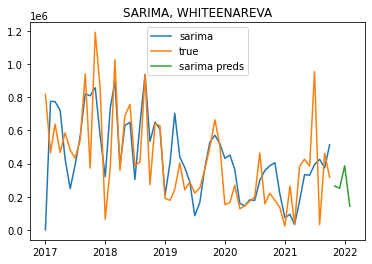

0 0 0
---WALLLIAMSUDI---
************ПЛОХО************


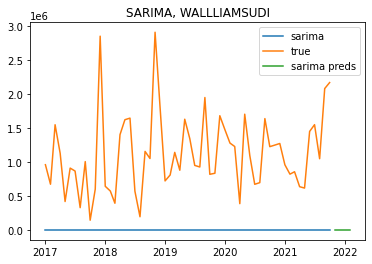

1 1 6
---TERRETHAARMA---


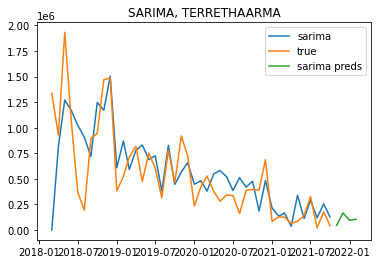

9 1 3
---SUNDROBBART---


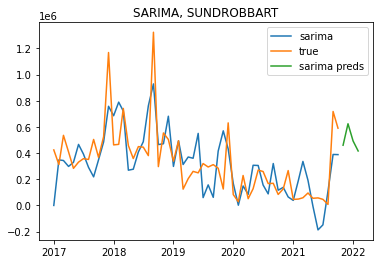

1 1 3
---SUDISHIEELLY---


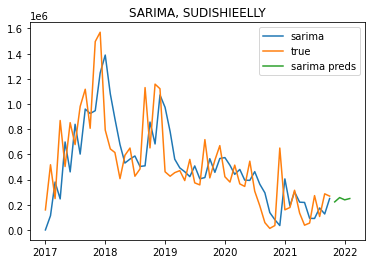

1 0 2
---SUDIEIDAYOSH---


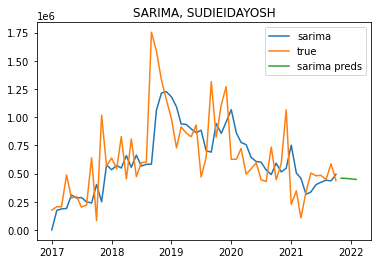

1 1 12
---SIGRREYHOWA---


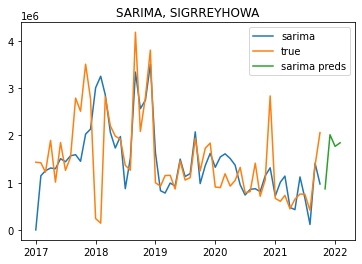

5 0 5
---SIGRMBERCARL---


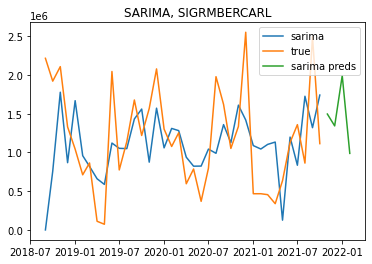

12 1 12
---SAMATINEWHIT---
************ПЛОХО************


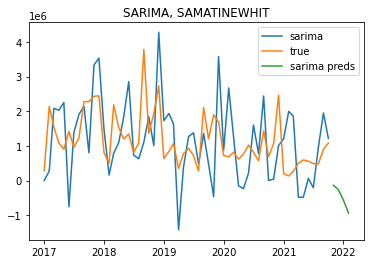

0 0 0
---SAMANDAYLAZA---
************ПЛОХО************


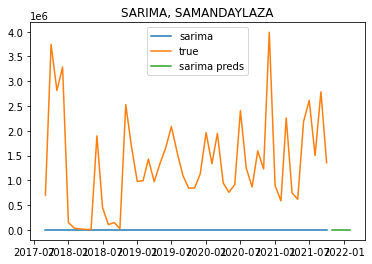

0 0 0
---RUDOCHELLYNE---
************ПЛОХО************


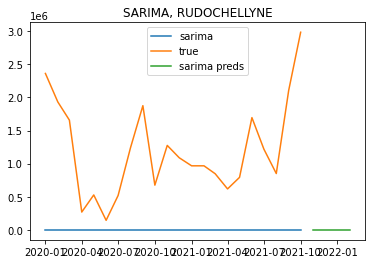

0 0 0
---RUDOALLYCATH---
************ПЛОХО************


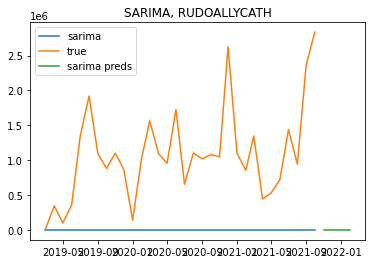

3 1 3
---ROBZAROCATH---


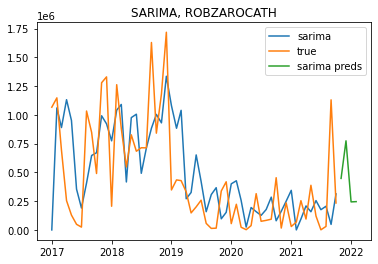

3 1 3
---ROBXIMOJEAN---


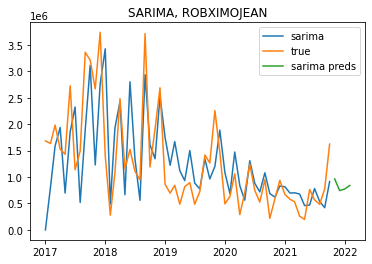

9 0 0
---ROBUREARUTH---


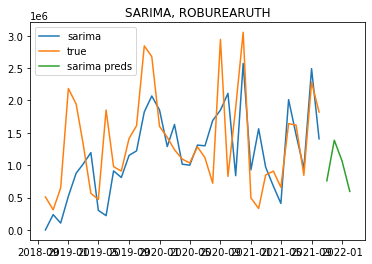

1 1 1
---RHEBNALDCIND---


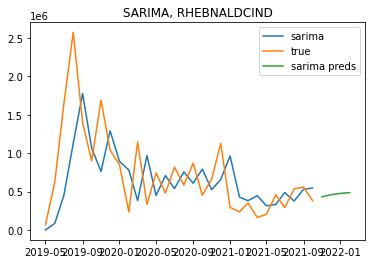

5 0 5
---REYXIMOMAXI---


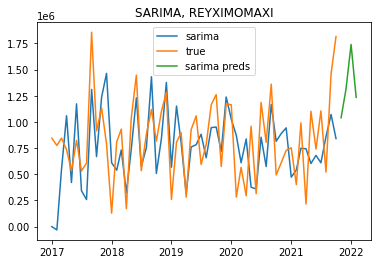

0 0 0
---REYETTEARLE---
************ПЛОХО************


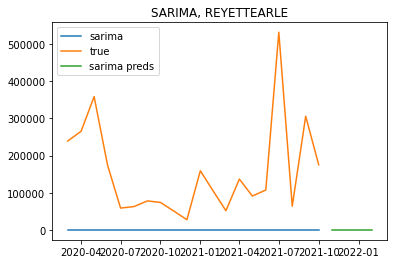

3 0 3
---REVAJAYENOLA---


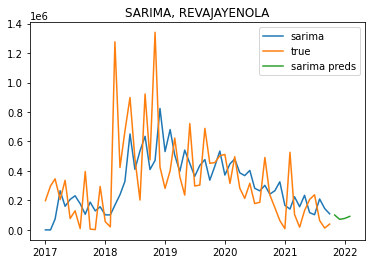

0 0 0
---REENOVANALBE---
************ПЛОХО************


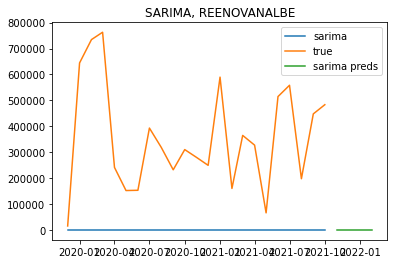

0 1 0
---REENMARXKAIT---
************ПЛОХО************


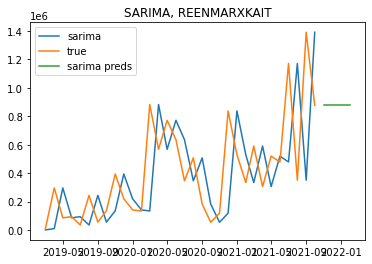

1 0 1
---REENESHAALON---


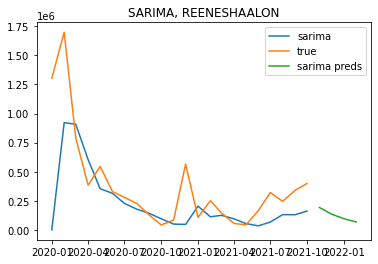

3 1 1
---PAMUEIDAASHL---


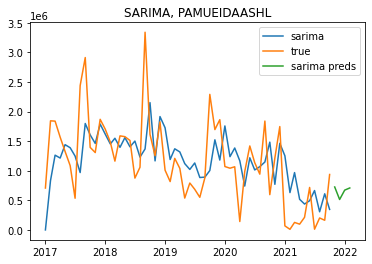

7 0 12
---ONEILONACARL---


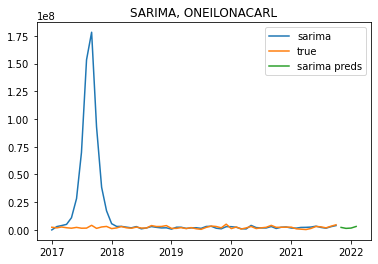

6 1 6
---NOVEERINKAIT---


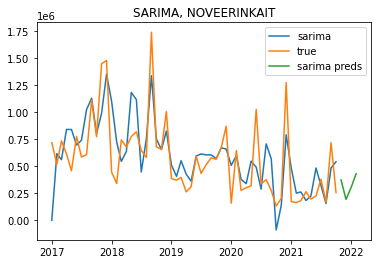

0 0 0
---NOVEARLADUAN---
************ПЛОХО************


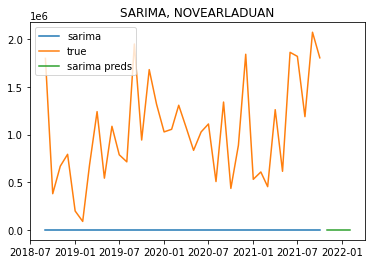

3 1 3
---MITCKEVAALBE---


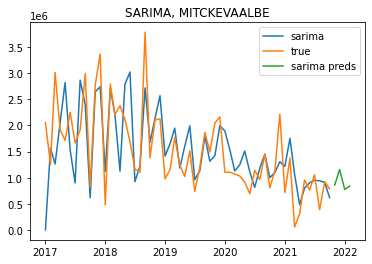

1 1 2
---MITCERTOKEVA---


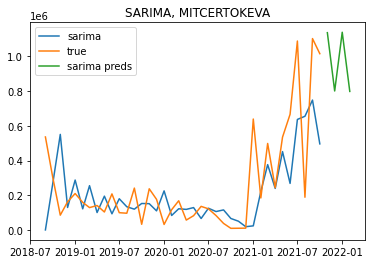

1 0 1
---MITCELLATERR---


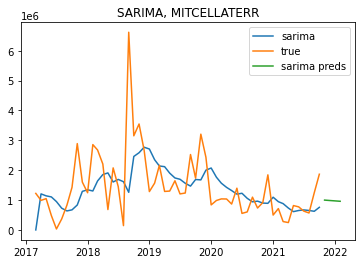

0 0 0
---MICHRTIEJEAN---
************ПЛОХО************


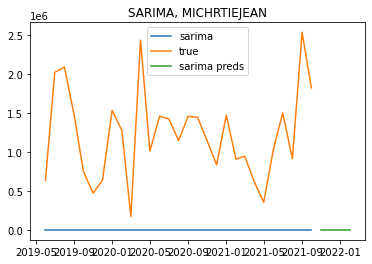

9 0 12
---MICHICKIKARR---
************ПЛОХО************


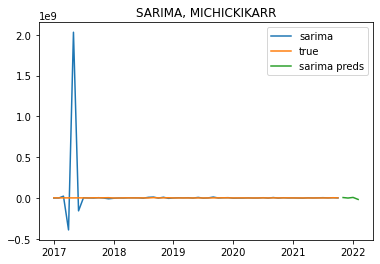

8 1 4
---MERCTTNYLEAT---


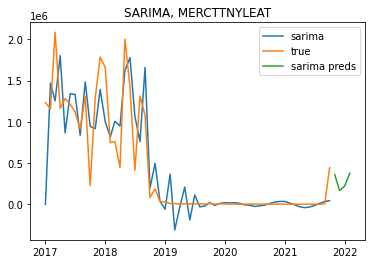

1 1 1
---MERCSAACJULI---


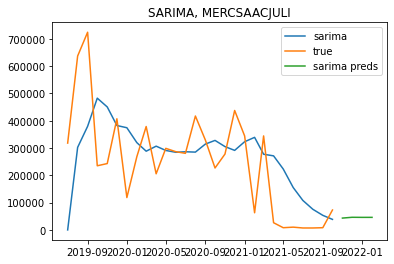

6 1 1
---MERCNDAYLEAN---


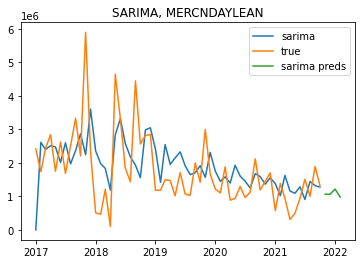

4 0 3
---MERCIBALKEVA---


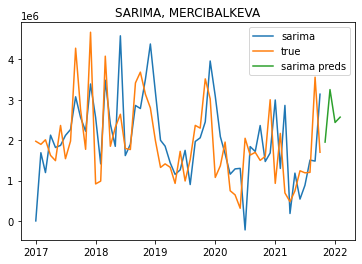

0 0 0
---MAYNINDALAZA---
************ПЛОХО************


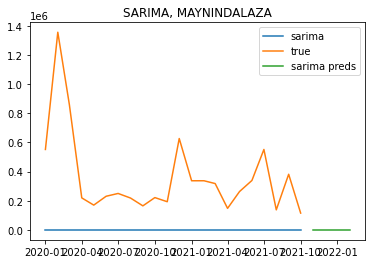

9 1 3
---MAYNHEBARUTH---


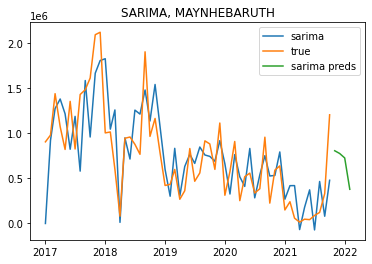

11 1 11
---MAYNETHATERR---
************ПЛОХО************


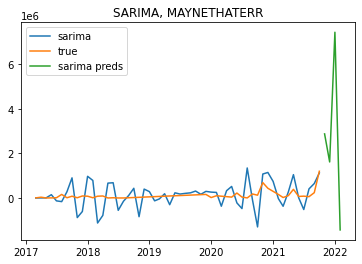

1 2 6
---MAXIVETAAMBE---


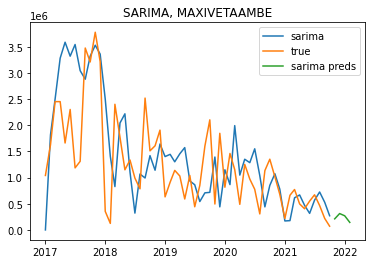

1 1 3
---MAXIRUBYDESM---


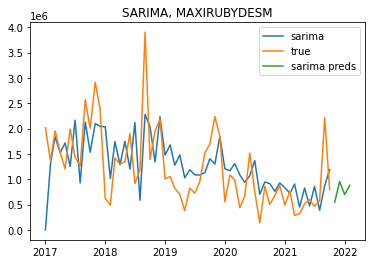

1 0 1
---MAXIOVANLAKE---


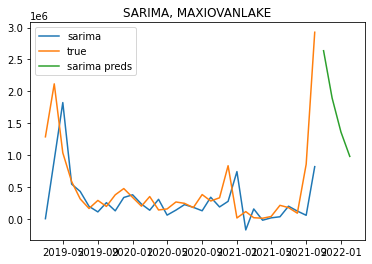

7 0 1
---MALILIAMBART---


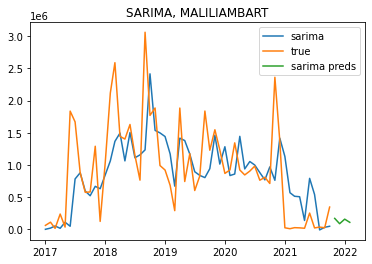

0 1 12
---MALIEENAKEVA---


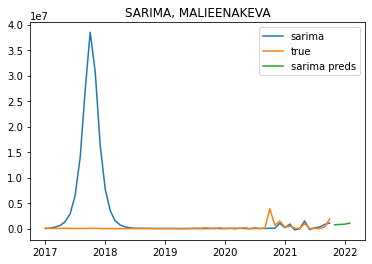

8 1 2
---MALIAHAMRICK---


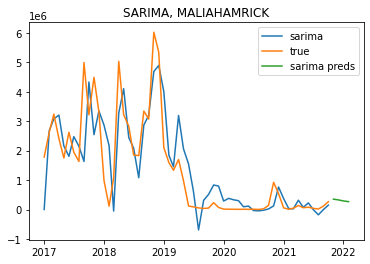

9 0 12
---LYNEUTHELAKE---


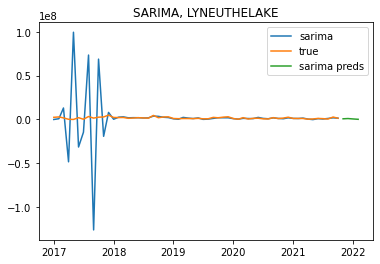

6 1 3
---LILLLIZAARMA---
************ПЛОХО************


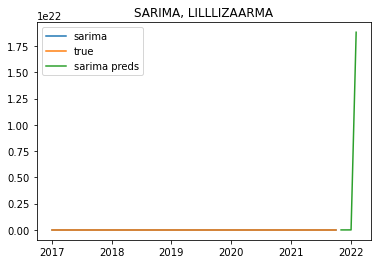

1 1 1
---LILLCHELCOLL---


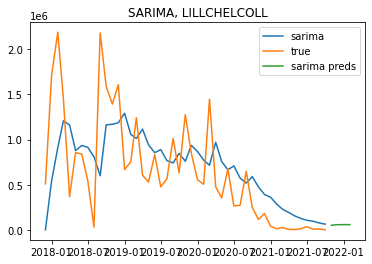

5 1 5
---LILLATHARIGO---


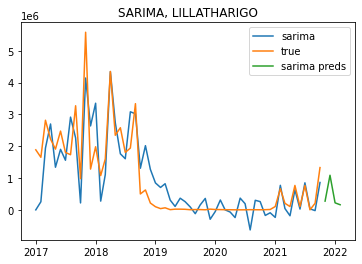

0 1 0
---LAZAJENEONEI---
************ПЛОХО************


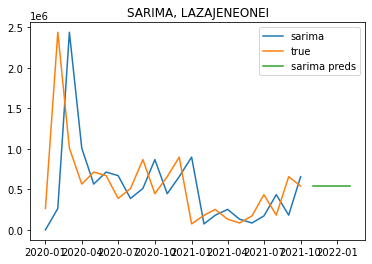

12 1 12
---LAZAABELEAN---


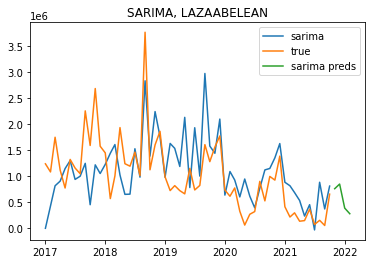

1 1 1
---LAVEWARDDUAN---


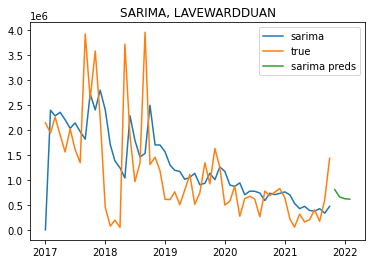

2 1 2
---LAVEETTEBRIT---


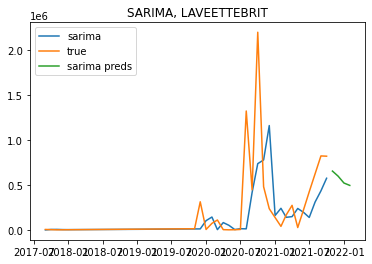

6 0 2
---LARIONIODONO---


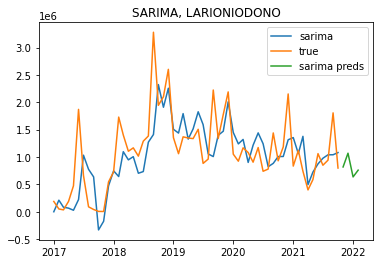

0 0 0
---LAKENDAYRICK---
************ПЛОХО************


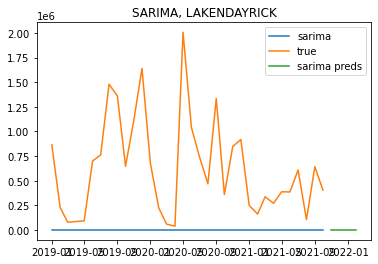

5 1 6
---LAKEMARXELLY---


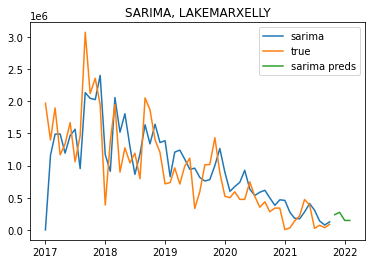

1 1 2
---KRISRRIEHAL---


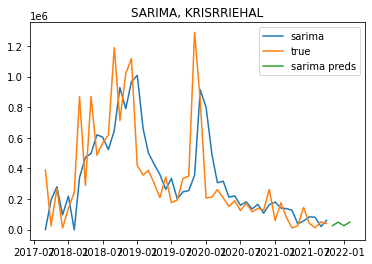

1 1 2
---KEVAROBRIGO---


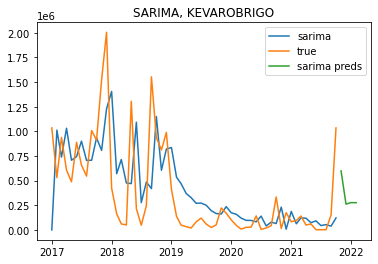

11 0 0
---KARRVETARUBY---


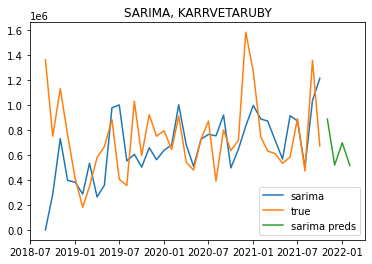

1 1 1
---JAYEMONDROSE---


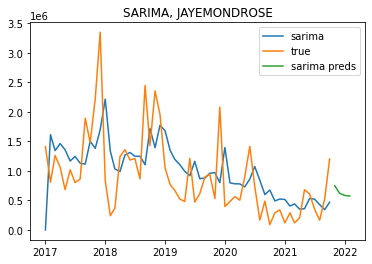

0 0 0
---ISAARICKRHEB---
************ПЛОХО************


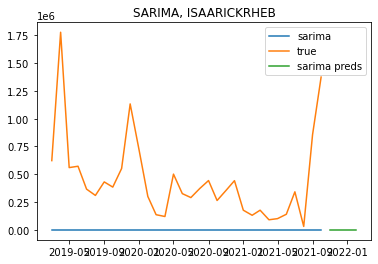

2 1 3
---ISAALEENREVA---


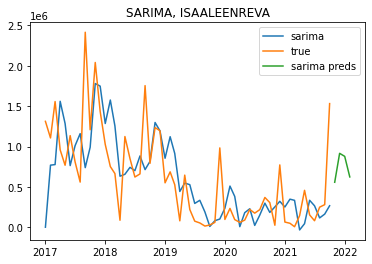

0 0 0
---ILSERISAELIZ---
************ПЛОХО************


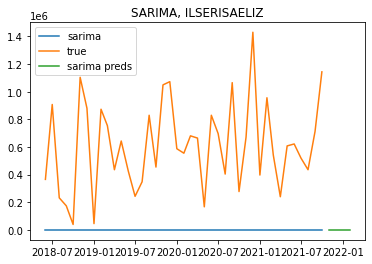

1 1 1
---HOWAESHADORE---


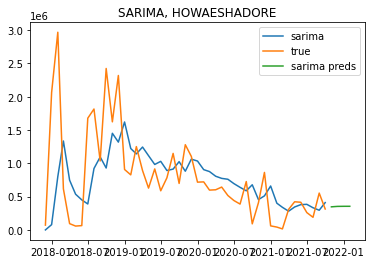

0 1 0
---HARLTTNYSIGR---
************ПЛОХО************


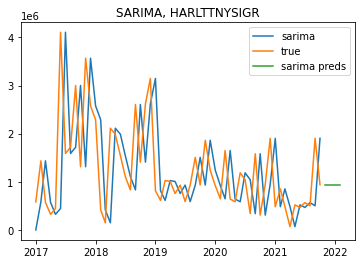

0 0 0
---HARLETTEANTO---
************ПЛОХО************


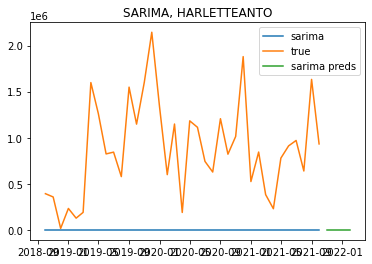

5 1 5
---HALRRONARLE---
************ПЛОХО************


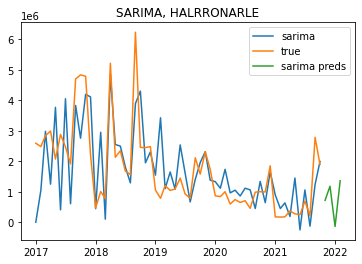

4 0 0
---HALEENAKAIT---


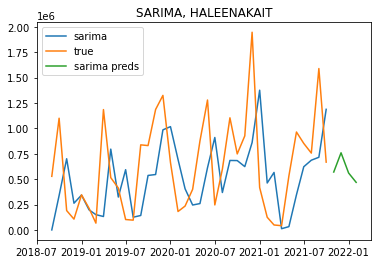

1 1 10
---ETHAKEVASHER---


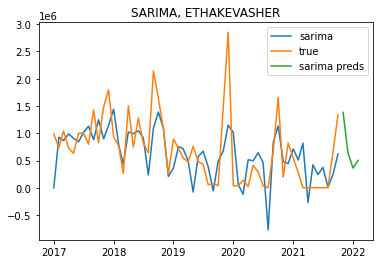

5 1 5
---ERICRICKPAMU---


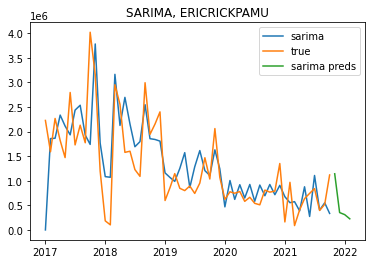

6 1 6
---ERICILSEWALL---


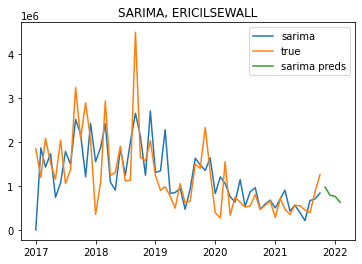

1 1 1
---ERICAHAMJULI---


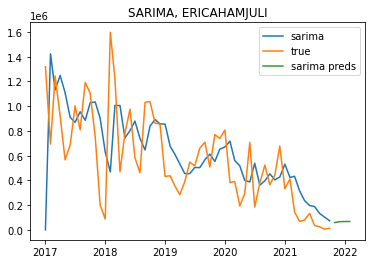

0 0 0
---ELLYGRIDMICH---
************ПЛОХО************


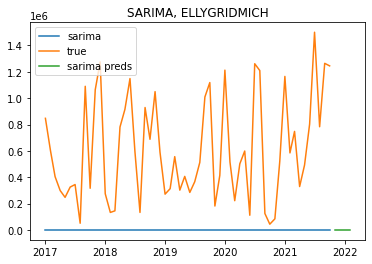

0 0 0
---ELIZKEVACARL---
************ПЛОХО************


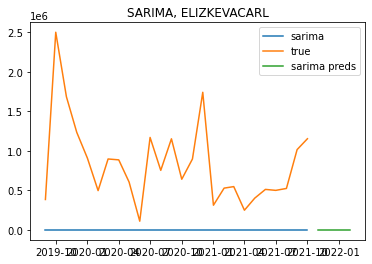

1 2 2
---ELIZJAYETHOR---


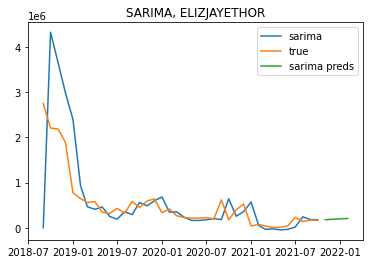

1 1 2
---DONOLIAMMAXI---


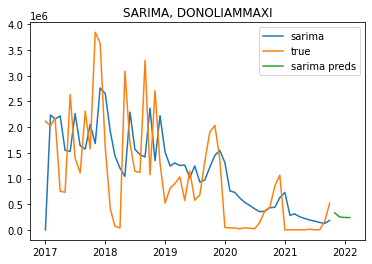

1 0 1
---DONOANHANH---


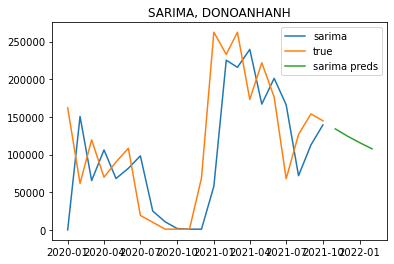

1 1 12
---DONARANGAURE---
************ПЛОХО************


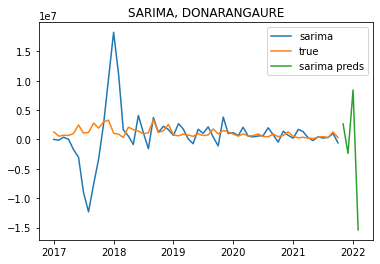

0 0 0
---CINDLINARIGO---
************ПЛОХО************


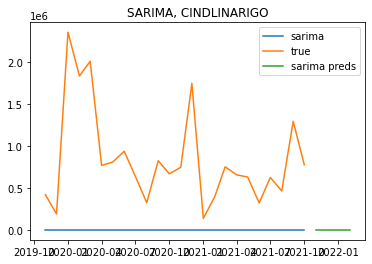

8 0 0
---CARLTINEHAL---


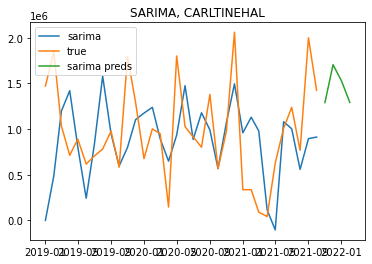

0 1 0
---CARLLEENGRAH---
************ПЛОХО************


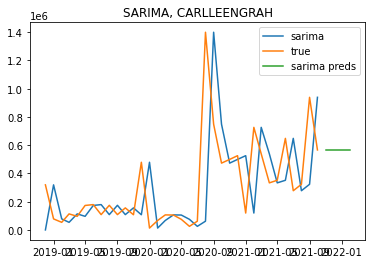

6 2 3
---BRITTINERUTH---
************ПЛОХО************


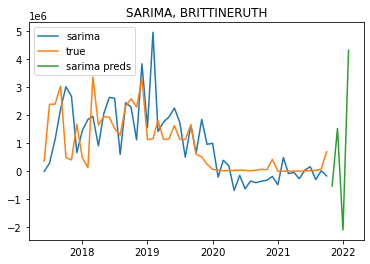

1 0 1
---BRITNARDONEI---


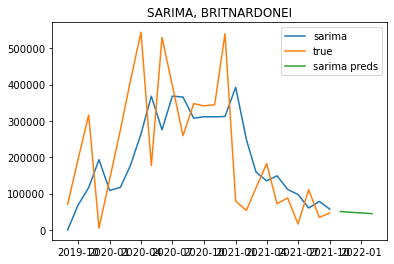

1 1 3
---BRITEIDALAKE---


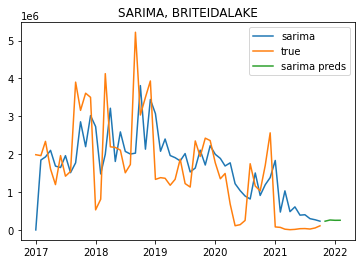

5 1 5
---BRITABEREEN---
************ПЛОХО************


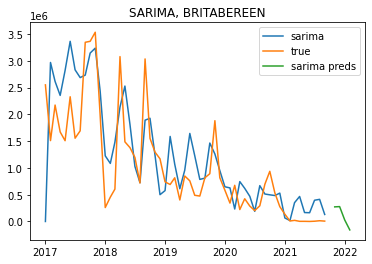

2 1 4
---ASHLNALDJULI---


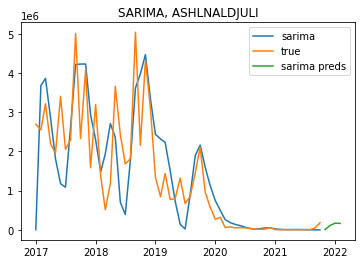

12 1 12
---ASHLESHALAZA---


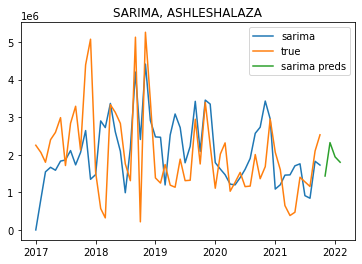

0 0 0
---ARTISAACMICH---
************ПЛОХО************


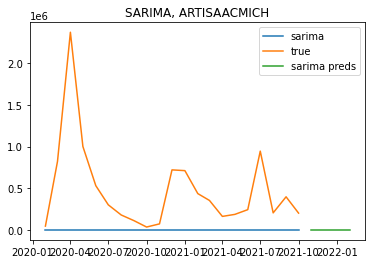

12 1 12
---ARTILANDARTI---
************ПЛОХО************


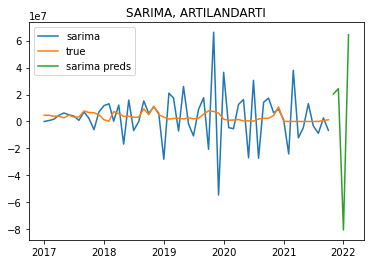

0 1 0
---ARTIERINILSE---
************ПЛОХО************


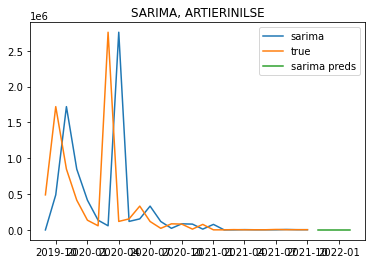

1 1 2
---ARLENARDLAKE---


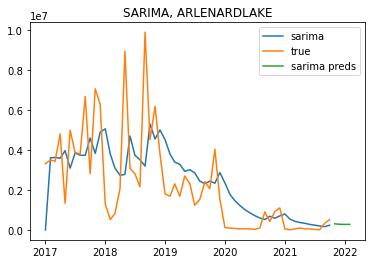

1 0 1
---ARLEETTAAURE---


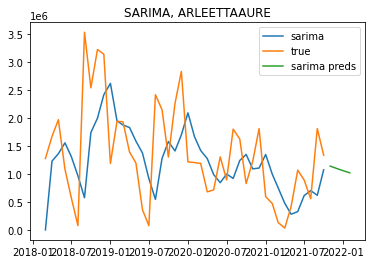

0 1 0
---ANIBAHAMKARR---
************ПЛОХО************


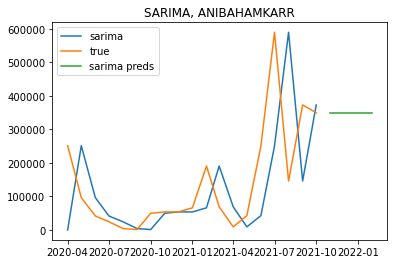

1 0 1
---AMBENORACIND---


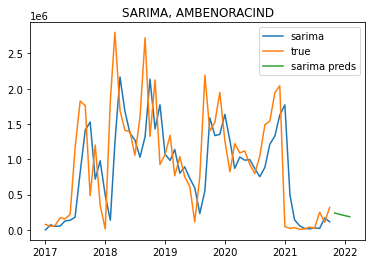

12 1 12
---ALONANDALAKE---
************ПЛОХО************


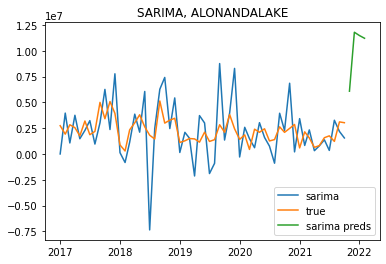

0 0 0
---ALONALLYKATH---
************ПЛОХО************


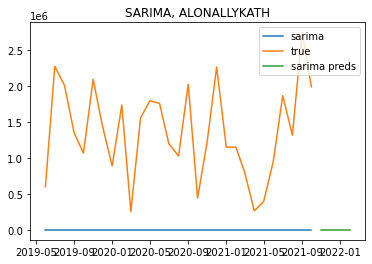

1 0 1
---ALBELINAJULI---


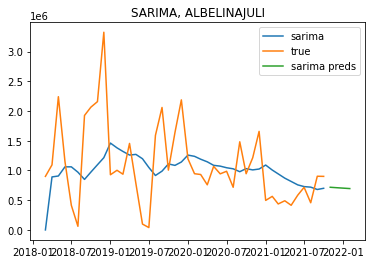

0 0 0
---ABEETTEABE---
************ПЛОХО************


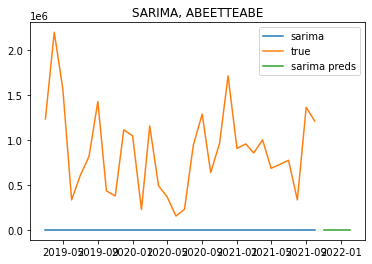

6 1 3
---ABEAHAMASHL---
************ПЛОХО************


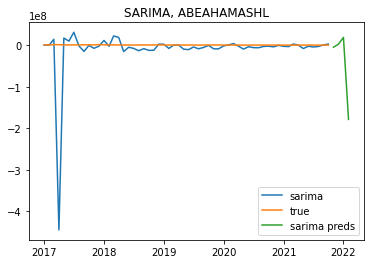

In [430]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"] 

bad_sku = {}
for sku_name in tqdm(test.sku_name.unique()):
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>=18:
        observations = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        ts = make_ts(observations, ds, method = 'smart')
        #ts = make_ts(observations, ds, method = 'linear')
        
        if len(ts)<=24:
            lags = 8
        else:
            lags=12
        
        pdq= parameters_for_arima(ts, lags=lags, mod=0)
        model = sm.tsa.statespace.SARIMAX(ts, order=pdq, enforce_stationarity=False, enforce_invertibility=False)
        output = model.fit()
        result = output.predict()
        preds=[]
        preds_dates=[]
        if max(result.index).year == 2021:
            dates_for_preds=['2021-11-01','2021-12-01','2022-01-01','2022-02-01']
            for i, date in enumerate(dates_for_preds):
                t=np.datetime64(date, "M")
                pred = output.predict(t).item()
                lst.append([sku_name + extra[i], pred])
                preds.append(pred)
                preds_dates.append(t)
        else:
            current_date = max(result.index).asm8.astype('datetime64[M]')
            for i in range(1,5):
                t = current_date+i
                pred = output.predict(t).item()
                lst.append([sku_name + extra[i-1], pred])
                preds.append(pred)
                preds_dates.append(t)
        preds = pd.Series(data=preds, index=preds_dates)
        print(f'---{sku_name}---')
        if (pdq[0]==0 and pdq[2]==0) or max(preds)/max(ts) > 2 or preds[preds<0].count() > 0:
            print('************ПЛОХО************')
            if (pdq[0]==0 and pdq[2]==0):
                bad_sku[sku_name]='Вырожденная модель'
            else:
                bad_sku[sku_name]='Неприемлимые значения'
        plt.title(f'SARIMA, {sku_name}')
        plt.plot(result)
        plt.plot(ts)
        plt.plot(preds)
        plt.legend(['sarima','true','sarima preds'])
        plt.show()
        
    elif temp.shape[0]>=1:
        observations = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        #ts = make_ts(observations, ds, method = 'smart')
        ts = make_ts(observations, ds, method = 'linear')
        
        # model = ETSModel(ts).fit()
        # preds = model.forecast(4)
        # preds = preds.reset_index(drop=True)
        # for i in range(4):
        #     lst.append([sku_name + extra[i], preds[i]])
        
        last_ts_date = max(ts.index).asm8.astype('datetime64[M]')
        cumulative_coefs = np.cumprod(coefs_for_next_observs[last_ts_date+1:])
        for i in range(4):
            pred = ts[last_ts_date]*cumulative_coefs[-4+i]
            lst.append([sku_name + extra[i], pred])
        
    elif temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 30000])
sub = pd.DataFrame(data=lst, columns = columns)

Доработка плохих sku_name

Причины доработки (достаточно одной)
- у модели арима AR=MA=0
- Есть предсказания которые минимум в 2 раз больше максимума наблюдений товара
- Есть предсказания отрицательные

Как дорабатываются
- Плохие sku_name, которые имеют неприемлимые значения, будут дорабатываться перебором арим и арима с наименьшим mse и потом берется модуль ее предсказаний
- Плохие sku_name, у корых получились вырожденные аримы, будут дорабатываться скользящими средними с аддитивным трендом и сезонностью / общим трендом

In [431]:
bad_sku

{'WALLLIAMSUDI': 'Вырожденная модель',
 'SAMATINEWHIT': 'Неприемлимые значения',
 'SAMANDAYLAZA': 'Вырожденная модель',
 'RUDOCHELLYNE': 'Вырожденная модель',
 'RUDOALLYCATH': 'Вырожденная модель',
 'REYETTEARLE': 'Вырожденная модель',
 'REENOVANALBE': 'Вырожденная модель',
 'REENMARXKAIT': 'Вырожденная модель',
 'NOVEARLADUAN': 'Вырожденная модель',
 'MICHRTIEJEAN': 'Вырожденная модель',
 'MICHICKIKARR': 'Неприемлимые значения',
 'MAYNINDALAZA': 'Вырожденная модель',
 'MAYNETHATERR': 'Неприемлимые значения',
 'LILLLIZAARMA': 'Неприемлимые значения',
 'LAZAJENEONEI': 'Вырожденная модель',
 'LAKENDAYRICK': 'Вырожденная модель',
 'ISAARICKRHEB': 'Вырожденная модель',
 'ILSERISAELIZ': 'Вырожденная модель',
 'HARLTTNYSIGR': 'Вырожденная модель',
 'HARLETTEANTO': 'Вырожденная модель',
 'HALRRONARLE': 'Неприемлимые значения',
 'ELLYGRIDMICH': 'Вырожденная модель',
 'ELIZKEVACARL': 'Вырожденная модель',
 'DONARANGAURE': 'Неприемлимые значения',
 'CINDLINARIGO': 'Вырожденная модель',
 'CARLLEE

  0%|          | 0/36 [00:00<?, ?it/s]

---SAMATINEWHIT---


  0%|          | 0/9 [00:00<?, ?it/s]

pdq : (1, 1, 12), mse : 1.085040357135613e+16
pdq : (0, 1, 12), mse : 515402764106.1586
pdq : (12, 1, 0), mse : 561590790504.6171
pdq : (12, 1, 1), mse : 569056114530.605
pdq : (0, 1, 1), mse : 581821528608.6489
Было: -137154.62, стало: 909614.3
Было: -260949.89, стало: 677199.74
Было: -569229.22, стало: 715878.29
Было: -937974.95, стало: 993878.99


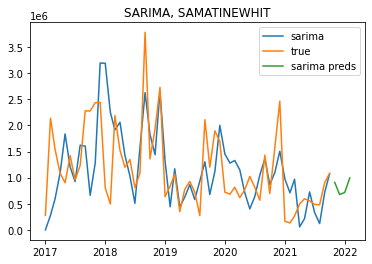



---MICHICKIKARR---


  0%|          | 0/6 [00:00<?, ?it/s]

pdq : (12, 0, 0), mse : 1316219187836.896
pdq : (4, 0, 12), mse : 1632043800311.4531
pdq : (0, 0, 12), mse : 5.426991786618622e+16
pdq : (4, 0, 0), mse : 980876736282.766
pdq : (0, 0, 0), mse : 3972741403015.435
Было: 6053589.89, стало: 1985085.38
Было: -17762.47, стало: 2643499.28
Было: 7599716.62, стало: 2007512.52
Было: -17167775.07, стало: 1947620.28


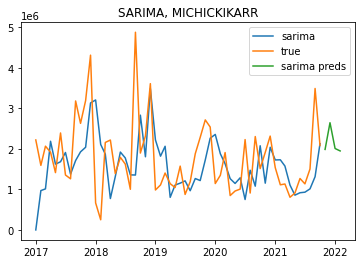



---MAYNETHATERR---


  0%|          | 0/9 [00:00<?, ?it/s]

pdq : (11, 1, 1), mse : 5800749772.306
pdq : (11, 1, 0), mse : 7919087015.669
pdq : (1, 1, 11), mse : 10987415389.5855
pdq : (0, 1, 11), mse : 3320222458338.0513
pdq : (1, 1, 1), mse : 26914098711.5224
Было: 2878117.95, стало: 1428770.85
Было: 1618044.39, стало: 1275966.96
Было: 7441970.76, стало: 682817.04
Было: -1433224.69, стало: 9925.67


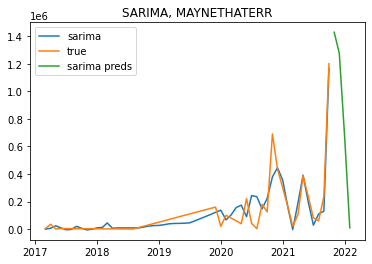



---LILLLIZAARMA---


  0%|          | 0/9 [00:00<?, ?it/s]

pdq : (6, 1, 0), mse : 154775639068.9224
pdq : (6, 1, 1), mse : 151249435274.0346
pdq : (0, 1, 3), mse : 174052513788.8174
pdq : (1, 1, 3), mse : 174126361206.9542
pdq : (0, 1, 1), mse : 174530669072.918
Было: 11536187911.97, стало: 1115621.25
Было: 135783401242531.9, стало: 1231765.18
Было: 1.5983225978964698e+18, стало: 1299701.02
Было: 1.8814045929050613e+22, стало: 989925.15


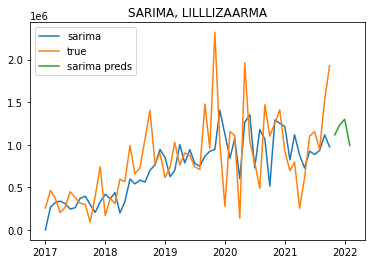



---HALRRONARLE---


  0%|          | 0/12 [00:00<?, ?it/s]

pdq : (5, 1, 5), mse : 1100683512535.3586
pdq : (1, 1, 5), mse : 1027198445737.8904
pdq : (0, 1, 5), mse : 1073007290912.7848
pdq : (5, 1, 0), mse : 1205630289560.3484
pdq : (5, 1, 1), mse : 1227742049183.4668
Было: 718318.98, стало: 1072029.4
Было: 1181245.59, стало: 1158340.21
Было: -140398.6, стало: 28443.11
Было: 1358366.14, стало: 649397.79


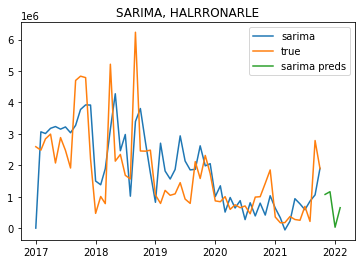



---DONARANGAURE---


  0%|          | 0/12 [00:00<?, ?it/s]

pdq : (0, 1, 12), mse : 1256376681686331.5
pdq : (12, 1, 3), mse : 390860182334.6712
pdq : (12, 1, 0), mse : 400599658445.1198
pdq : (12, 1, 1), mse : 396813754415.8281
pdq : (1, 1, 12), mse : 8224020954418.599
Было: 2638125.53, стало: 698131.24
Было: -2366209.3, стало: 1005900.13
Было: 8426352.68, стало: 408686.62
Было: -15407892.51, стало: 523714.56


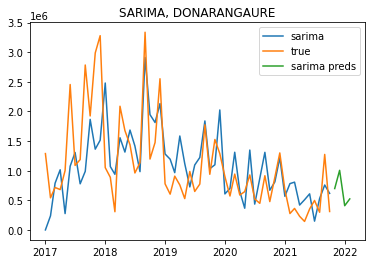



---BRITTINERUTH---


  0%|          | 0/12 [00:00<?, ?it/s]

pdq : (6, 2, 1), mse : 536304693826.5743
pdq : (6, 2, 2), mse : 536894916899.2351
pdq : (6, 2, 0), mse : 677805784384.2549
pdq : (0, 2, 3), mse : 656445907330.0774
pdq : (1, 2, 3), mse : 620356261424.8386
Было: -522387.23, стало: 350848.42
Было: 1529185.72, стало: 428575.54
Было: -2090509.81, стало: 527246.72
Было: 4316691.46, стало: 388969.32


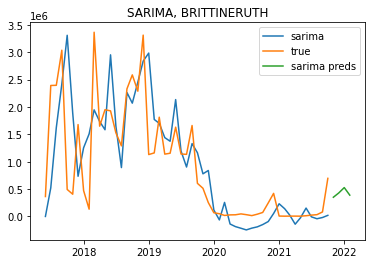



---BRITABEREEN---


  0%|          | 0/12 [00:00<?, ?it/s]

pdq : (5, 1, 5), mse : 311869571452.6531
pdq : (1, 1, 5), mse : 473202735311.6645
pdq : (0, 1, 5), mse : 445553308677.6152
pdq : (5, 1, 0), mse : 453674253366.0479
pdq : (5, 1, 1), mse : 453967651076.4825
Было: 273056.11, стало: 188136.24
Было: 278078.46, стало: 227266.91
Было: 29206.4, стало: 162337.58
Было: -157263.15, стало: 84289.01


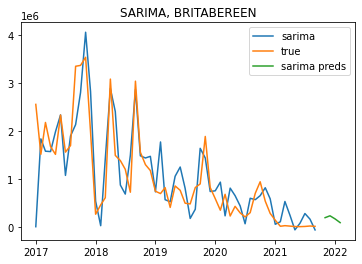



---ARTILANDARTI---


  0%|          | 0/12 [00:00<?, ?it/s]

pdq : (1, 1, 12), mse : 5272379753170.4795
pdq : (0, 1, 12), mse : 5908988942207320.0
pdq : (12, 1, 0), mse : 4798695895390.041
pdq : (12, 1, 1), mse : 4800550166334.489
pdq : (11, 1, 0), mse : 4756886863244.053
Было: 20405116.79, стало: 4810664.93
Было: 24317787.39, стало: 7491629.65
Было: -80434630.29, стало: 2613889.73
Было: 64337388.3, стало: 1510863.36


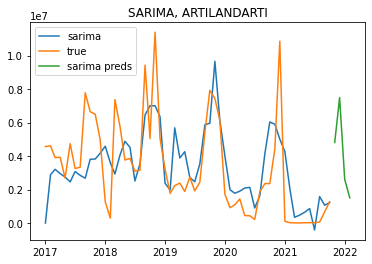



---ALONANDALAKE---


  0%|          | 0/9 [00:00<?, ?it/s]

pdq : (1, 1, 12), mse : 754234059969.7954
pdq : (0, 1, 12), mse : 792083157954.7372
pdq : (12, 1, 0), mse : 1040317060700.8114
pdq : (12, 1, 1), mse : 1047993564703.6868
pdq : (0, 1, 1), mse : 1312711039782.62
Было: 6079704.92, стало: 2843684.35
Было: 11791727.89, стало: 3538711.95
Было: 11471110.54, стало: 2718332.01
Было: 11208772.63, стало: 2939364.65


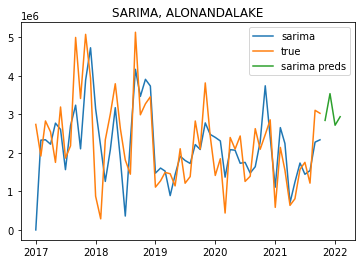



---ABEAHAMASHL---


  0%|          | 0/20 [00:00<?, ?it/s]

pdq : (6, 1, 0), mse : 47575491948.8384
pdq : (6, 1, 1), mse : 47744408752.8298
pdq : (6, 1, 2), mse : 43914370475.5205
pdq : (2, 1, 3), mse : 33048057814.4989
pdq : (3, 1, 3), mse : 33132121313.8953
Было: -4970733.98, стало: 33023.17
Было: 2099819.8, стало: 46899.7
Было: 18492654.3, стало: 22111.4
Было: -178807776.36, стало: 39792.92


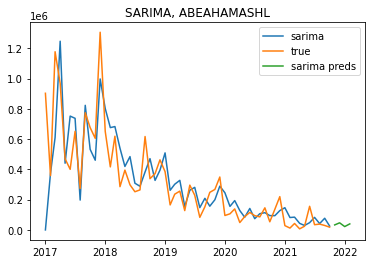

In [432]:
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"] 

for sku_name, cause in tqdm(bad_sku.items()):
    temp = train[train.sku_name == sku_name]
    if cause == 'Неприемлимые значения':
        observations = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        #ts = make_ts(observations, ds, method = 'smart')
        ts = make_ts(observations, ds, method = 'linear')
        if len(ts)<24:
            lags = 9
        else:
            lags=12

        print(f'---{sku_name}---')
        pdq = parameters_for_arima(ts, lags=lags, mod=1)
        configurations = sarimax_gridsearch(ts, pdq, [(0,0,0,0)])
        min_mse = 10e20
        best_pdq = ()
        for pdq in configurations['pdq']:
            model = sm.tsa.statespace.SARIMAX(ts, order=pdq, enforce_stationarity=False, enforce_invertibility=False)
            output = model.fit()
            result = output.predict()
            mse = mean_squared_error(ts, result)
            print(f'pdq : {pdq}, mse : {round(mse,4)}')
            if min_mse>mse:
                min_mse=mse
                best_pdq = pdq

        model = sm.tsa.statespace.SARIMAX(ts, order=best_pdq, enforce_stationarity=False, enforce_invertibility=False)
        output = model.fit()
        result = output.predict()
        preds=[]
        preds_dates=[]
        if max(result.index).year == 2021:
            dates_for_preds=['2021-11-01','2021-12-01','2022-01-01','2022-02-01']
            for i, date in enumerate(dates_for_preds):
                index = sub[sub.Item_ID == sku_name + extra[i]].index
                t=np.datetime64(date, "M")
                pred = abs(output.predict(t).item())
                old_value = round(sub.loc[index, 'Target'].values[0],2)
                print(f'Было: {old_value}, стало: {round(pred,2)}')
                sub.loc[index, 'Target'] = pred
                #lst.append([sku_name + extra[i], pred])
                preds.append(pred)
                preds_dates.append(t)
        else:
            current_date = max(result.index).asm8.astype('datetime64[M]')
            for i in range(1,5):
                index = sub[sub.Item_ID == sku_name + extra[i-1]].index
                t = current_date+i
                pred = abs(output.predict(t).item())
                old_value = round(sub.loc[index, 'Target'].values[0],2)
                print(f'Было: {old_value}, стало: {round(pred,2)}')
                sub.loc[index, 'Target'] = pred
                #lst.append([sku_name + extra[i-1], pred])
                preds.append(pred)
                preds_dates.append(t)
        preds = pd.Series(data=preds, index=preds_dates)

        plt.title(f'SARIMA, {sku_name}')
        plt.plot(result)
        plt.plot(ts)
        plt.plot(preds)
        plt.legend(['sarima','true','sarima preds'])
        plt.show()
        print('\n')
    
    if cause == 'Вырожденная модель':
        observations = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        ts = make_ts(observations, ds, method = 'linear')
        # try:
        #     model = ETSModel(ts, trend = 'add', error = 'add', seasonal="add").fit()
        # except:
        #     model = ETSModel(ts, trend = 'add', error = 'add').fit()
        # preds = model.forecast(4)
        # preds = preds.reset_index(drop=True)
        # for i in range(4):
        #     index = sub[sub.Item_ID == sku_name + extra[i]].index
        #     sub.loc[index, 'Target'] = preds[i]
        
        last_ts_date = max(ts.index).asm8.astype('datetime64[M]')
        cumulative_coefs = np.cumprod(coefs_for_next_observs[last_ts_date+1:])
        for i in range(4):
            index = sub[sub.Item_ID == sku_name + extra[i]].index
            pred = ts[last_ts_date]*cumulative_coefs[-4+i]
            sub.loc[index, 'Target'] = pred

In [433]:
sub.to_csv(os.getcwd()+'\submission 47 (arima + general trend, years shift, dorabotka general trend).csv',index=False)

### Публичный бейзлайн (немного изменный, товары с давними данными заполняются 30000)

In [13]:
train_recent = train[train["ds"] >= "2021/01"]

In [648]:
medians = train_recent.groupby("sku_name")["sellin"].median().to_dict()

In [649]:
sku_names_test = test["sku_name"].unique()

In [650]:
missing = {}
for sku_name_test in sku_names_test:
    missing[sku_name_test] = 30000

In [651]:
test["Target"] = test["sku_name"].replace(medians).replace(missing).astype(int)

test["Item_ID"] = test["sku_name"] + "_" + test["month"].astype(str) + "_" + test["year"].astype(str)

In [652]:
test[["Item_ID", "Target"]].to_csv("submission 31 (public baseline 30000).csv", index=False)

Эксперементы с заполнением

In [653]:
x = [0,10,20,30,40,45,60,80]
y = [192045.46, 192034.54, 192012.71,191990.87,192006.58,192017.50,192050.25,192093.92]

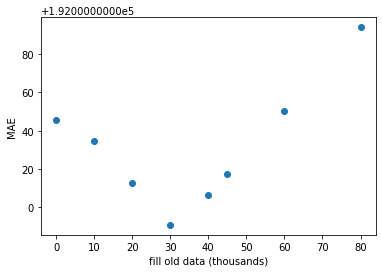

In [654]:
plt.scatter(x,y, marker = 'o')
plt.ylabel('MAE')
plt.xlabel('fill old data (thousands)')
plt.show()

**Важное замечание**:
<br/>Оказывается у всех товаров их тестового набора данных есть данные за 2021 год, кроме одного который вообще не представлен
<br/>То есть то что подбиралось чуть выше относилось чисто к 1ому товару, который не представлен

### Коэффициенты линейной регрессии у товаров

In [659]:
from sklearn.linear_model import LinearRegression

In [660]:
men_sku = test[test.CAT_GENDER_MEN == 1].sku_name.unique()
women_sku = test[test.CAT_GENDER_WOMEN == 1].sku_name.unique()

In [1079]:
men_reg_coefs = []
men_reg_intercepts = []

for sku_name in men_sku:
    obs = train_recent[train_recent.sku_name == sku_name]['sellin']
    ds = train_recent[train_recent.sku_name == sku_name]['ds'].values.astype('datetime64[M]')
    if len(obs)>3:
        ts = make_ts(obs, ds, method = 'smart', sku_name = sku_name)
        if sku_name == 'KEVAROBRIGO': # с этим sku_name происходит непонятная аномилая во время make_ts, разбираться в ней не хочется из за одной ошибки. В ручную исправлю недочет.
            ts[0]=obs[0]
        x = np.arange(1, len(ts.values)+1).reshape(-1, 1)
        y = np.array(ts.values).reshape(-1, 1)
        reg = LinearRegression().fit(x,y)
        men_reg_coefs.append(reg.coef_[0][0])
        men_reg_intercepts.append(reg.intercept_[0])

In [1080]:
women_reg_coefs = []
women_reg_intercepts = []

for sku_name in women_sku:
    obs = train_recent[train_recent.sku_name == sku_name]['sellin']
    ds = train_recent[train_recent.sku_name == sku_name]['ds'].values.astype('datetime64[M]')
    if len(obs)>3:
        ts = make_ts(obs, ds, method = 'smart', sku_name = sku_name)
        if sku_name == 'KEVAROBRIGO': # с этим sku_name происходит непонятная аномилая во время make_ts, разбираться в ней не хочется из за одной ошибки. В ручную исправлю недочет.
            ts[0]=obs[0]
        x = np.arange(1, len(ts.values)+1).reshape(-1, 1)
        y = np.array(ts.values).reshape(-1, 1)
        reg = LinearRegression().fit(x,y)
        women_reg_coefs.append(reg.coef_[0][0])
        women_reg_intercepts.append(reg.intercept_[0])

[]

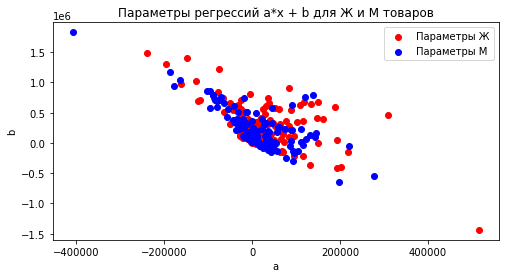

In [763]:
plt.figure(figsize=(8,4))
plt.title('Параметры регрессий a*x + b для Ж и М товаров')
plt.scatter(x = women_reg_coefs, y = women_reg_intercepts, color = 'red')
plt.scatter(x = men_reg_coefs, y = men_reg_intercepts, color = 'blue')
plt.legend(['Параметры Ж','Параметры М'])
plt.ylabel('b')
plt.xlabel('a')
plt.plot()

In [771]:
np.mean(men_reg_coefs), np.mean(men_reg_intercepts), np.mean(women_reg_coefs), np.mean(women_reg_intercepts)

(11174.176211298025, 204544.1840896985, 21916.8225849095, 261319.62900820284)

В облаках точек явных различий нет, они друг на друге

#### Отношения пика и предыдущего значения для товаров, у которых пики в декабре

In [984]:
cols=['sku_name','n_years','n_times','peak_to_previus','peak_to_previus_last']
lst = []
for sku_name in test.sku_name.unique():
    temp = train[train.sku_name == sku_name]
    peak_to_previus = []
    n_years = len(temp.year.unique())
    n_times = 0
    if temp.shape[0]>12:
        for year in temp.year.unique():
            month_peak = temp[temp.year == year].sort_values(by='sellin', ascending = False).head(1).month.item()
            if month_peak == 12:
                n_times+=1
                try:
                    prev_obs = temp[(temp.year == year) & (temp.month == 11)].sellin.item()
                    peak = temp[(temp.year == year) & (temp.month == 12)].sellin.item()
                    peak_to_previus.append(round(peak/prev_obs,2))
                except:
                    n_times-=1
    if n_times != 0:
        lst.append([sku_name, n_years, n_times, peak_to_previus, peak_to_previus[-1]])
sku_name_season_peaks = pd.DataFrame(data=lst, columns=cols)

In [985]:
sku_name_season_peaks.head()

sku_name  n_years  n_times peak_to_previus  peak_to_previus_last
0  WALLLIAMSUDI        5        1          [4.76]                  4.76
1   SUNDROBBART        5        2    [2.22, 5.02]                  5.02
2  SUDISHIEELLY        5        1          [1.05]                  1.05
3  SIGRMBERCARL        4        1          [1.33]                  1.33
4  SAMATINEWHIT        5        1           [1.0]                  1.00

### Линейная регрессия на данных за 2021 год

**Страта 1**
- Если у товара 4 и более записей, то учим линейную регрессию и ей прогнозируем. Отрицательные прогнозы заменяем на медиану
- Если меньше, то предсказываем медианой
- Для не представленного товара прогноз 30000

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 277544.33

Сравнив свои предсказания регрессией с медианой выяснилось следующее:
- все предсказания >= меданы: 226
- некоторые предсказания >= медианы: 28
- все предсказания < медианы: 44

**Страта 2**
- Если у товара 4 и более записей, считаем 25% квантиль
- Если меньше, то предсказываем медианой
- Для не представленного товара прогноз 30000

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 207405.22

**Страта 3**
- Представленные товары представляем медианой, если у товара встречаются пики в декабрях, то соответсвенно домножаем медиану на коэф пика (только для прогноза на 12.2021) 
- Для не представленного товара прогноз 30000

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 198356.86

**Страта 4 (возможно пробелы в месяцах означают не пробелы, а то что в эти месяца sellin=0)**
- Если у товара 4 и более записей, то медиана
- Иначе 0 
- Для не представленного товара прогноз 30000

Стратегия выше дала следующие результаты:
- MAE на тестовых данных: 201466.20

**Страта 5**
- страта 2 + страта 3

Стратегия выше дала следующие результаты:
- ХУЕТА

In [996]:
lst=[]
columns=["Item_ID", "Target"]
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]

# a={'pos':0, 'neg':0, 'both':0}
bad_sku = {}
for sku_name in tqdm(test.sku_name.unique()):
    temp = train_recent[train_recent.sku_name == sku_name]
    if temp.shape[0]>=4:
        obs = train_recent[train_recent.sku_name == sku_name]['sellin']
        ds = train_recent[train_recent.sku_name == sku_name]['ds'].values.astype('datetime64[M]')
        ts = make_ts(obs, ds, method = 'smart')
#         x = np.arange(1, len(ts.values)+1)
#         y = np.array(ts.values)
#         reg = LinearRegression().fit(x.reshape(-1, 1),y.reshape(-1, 1))
#         y_hat = reg.predict(x.reshape(-1, 1))
#         max_x_date = max(ts.index).asm8.astype('datetime64[M]')
#         dates_range = int(np.datetime64('2022-02', 'M') -  max_x_date)
#         x_for_forecast = np.arange(x[-1] + 1, x[-1] + dates_range + 1)
#         y_forecast = reg.predict(x_for_forecast.reshape(-1, 1))
#         median = temp['sellin'].median()
        
#         for i,forecast in enumerate(y_forecast[-4:]):
#             if forecast>=0:
#                 lst.append([sku_name + extra[i], forecast[0]])
#             else:
#                 y_forecast[-4:][i] = median
#                 lst.append([sku_name + extra[i], median])
    
#         k=len(y_forecast[-4:][y_forecast[-4:]>=median]) 
#         if k==4:
#             a['pos']+=1
#         elif k>0:
#             a['both']+=1
#         else: a['neg']+=1

        # plt.title(f'Linear, {sku_name}')
        # plt.plot(x,y)
        # plt.plot(x,y_hat)
        # plt.plot(x_for_forecast, y_forecast)
        # plt.axhline(y=median, color = 'purple', linestyle='--')
        # plt.legend(['True','Linear','Linear forecast', "Медиана"])
        # plt.show()
        
        
        # quan = np.quantile(temp['sellin'], 0.25)
        # for i in range(4):
        #     if len(sku_name_season_peaks[sku_name_season_peaks.sku_name == sku_name])>0:
        #         coef = sku_name_season_peaks[sku_name_season_peaks.sku_name == sku_name].peak_to_previus_last.item()
        #         lst.append([sku_name + extra[i], quan*coef])
        #     else:
        #         lst.append([sku_name + extra[i], quan])
        
    
        
    elif temp.shape[0]>=1:
        median = np.median(ts)
        for i in range(4):
            lst.append([sku_name + extra[i], median])
        
    elif temp.shape[0] == 0:
        for i in range(4):
            lst.append([sku_name + extra[i], 30000])
sub = pd.DataFrame(data=lst, columns = columns)

  0%|          | 0/382 [00:00<?, ?it/s]

In [997]:
sub.to_csv(os.getcwd()+'\submission 40 (median on 2 last obs).csv',index=False)

### Поиск общего тренда с сезонностью

Уберем годовой пробел в данных (2020 отсутствует), сместим все даты до него на 1 год вперед

In [415]:
train['ds'] = train.apply(func = date_column_2, axis=1)

In [366]:
train = train[train.ds>='2019-01-01']

In [306]:
def summary_trend(date_values, method = 'median'):
    trend_values = []
    for date, values in date_values.items():
        if method == 'median':
            trend_values.append(np.median(values))
        elif method == 'mean':
            trend_values.append(np.mean(values))
    return pd.Series(data = trend_values, index = date_values.index)    

In [416]:
dates = np.sort(train.ds.unique())
date_values = pd.Series(data = [[]]*len(dates), index = dates)
date_values2 = pd.Series(data = [[]]*len(dates), index = dates)

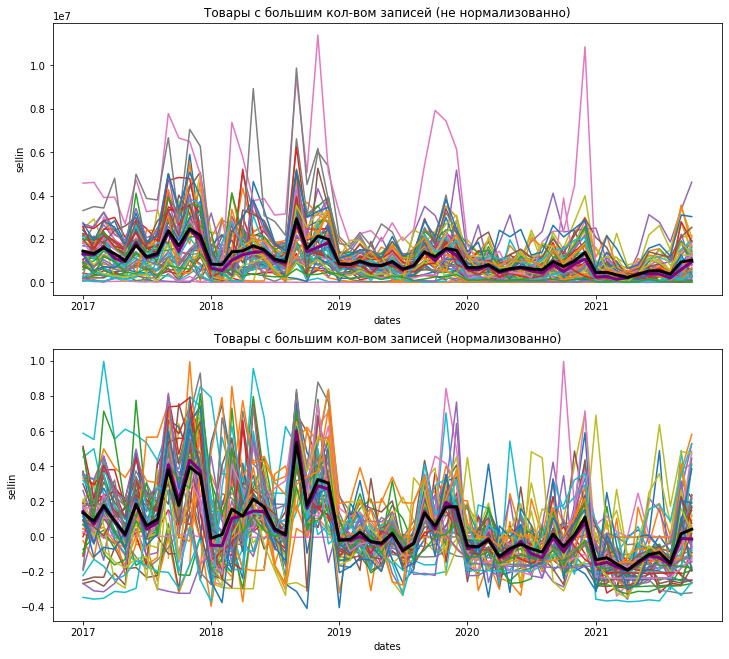

In [417]:
fig,axes = plt.subplots(2,1,figsize=(12,11))
axes[0].set_title('Товары с большим кол-вом записей (не нормализованно)')
axes[1].set_title('Товары с большим кол-вом записей (нормализованно)')
for sku_name in test.sku_name.unique():
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>=40:
        obs = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        ts = make_ts(obs, ds, method = 'linear')
        axes[0].plot(ts)
        for index,value in ts.items():
            date_values[index] = date_values[index] + [value]
        
        u = np.median(ts)
        #u = np.min(ts)
        #u = np.mean(ts)
        d = max(ts) - min(ts) 
        ts = (ts-u)/d
        axes[1].plot(ts)
        for index,value in ts.items():
            date_values2[index] = date_values2[index] + [value]

trend1_1 = summary_trend(date_values, method = 'median')
trend1_2 = summary_trend(date_values, method = 'mean')
axes[0].plot(trend1_1, linewidth=3, color = 'purple')
axes[0].plot(trend1_2, linewidth=3, color = 'black')

trend2_1 = summary_trend(date_values2, method = 'median')
trend2_2 = summary_trend(date_values2, method = 'mean')
axes[1].plot(trend2_1, linewidth=3, color = 'purple')
axes[1].plot(trend2_2, linewidth=3, color = 'black')

axes[0].set_ylabel('sellin')
axes[0].set_xlabel('dates')
axes[1].set_ylabel('sellin')
axes[1].set_xlabel('dates')
plt.show()

Построим SARIMA

Если на общем тренде (из средних) строить арима - ошибка 236к
<br/>Если на общем тренде (из медиан) строить арима - ошибка 209к

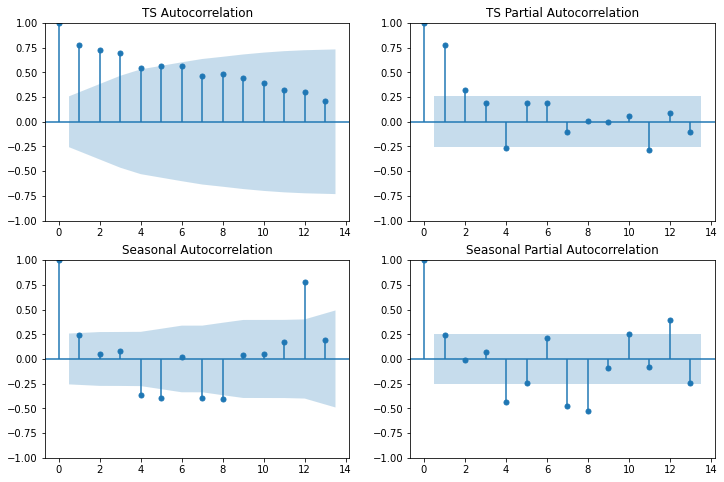

In [393]:
pdq, PDQs = parameters_for_sarima(trend1_1, lags=13, mod=1, seasonality=12)

In [394]:
configs = sarimax_gridsearch(trend1_1, pdq, PDQs, n_configurations=15)

  0%|          | 0/16 [00:00<?, ?it/s]

In [395]:
configs

pdq           pdqs         bic
0   (11, 0, 1)  (0, 2, 0, 12)  621.382098
1   (11, 0, 0)  (0, 2, 0, 12)  623.420421
2   (11, 0, 2)  (0, 2, 0, 12)  624.145605
3   (11, 0, 3)  (0, 2, 0, 12)  627.426200
4    (1, 0, 3)  (0, 2, 0, 12)  794.797956
5    (0, 0, 3)  (0, 2, 0, 12)  795.953607
6    (2, 0, 3)  (0, 2, 0, 12)  798.198812
7    (1, 0, 2)  (0, 2, 0, 12)  819.032578
8    (2, 0, 2)  (0, 2, 0, 12)  821.099862
9    (0, 0, 2)  (0, 2, 0, 12)  823.420155
10   (2, 0, 0)  (0, 2, 0, 12)  843.946252
11   (2, 0, 1)  (0, 2, 0, 12)  846.567917
12   (1, 0, 1)  (0, 2, 0, 12)  847.113799
13   (0, 0, 1)  (0, 2, 0, 12)  855.533243
14   (1, 0, 0)  (0, 2, 0, 12)  873.923327

In [403]:
model = sm.tsa.statespace.SARIMAX(trend1_1, order=configs.loc[1,'pdq'],seasonal_order = configs.loc[1,'pdqs'], enforce_stationarity=False, enforce_invertibility=False).fit()
preds = model.predict()
forecact = model.forecast('2022-02-01')

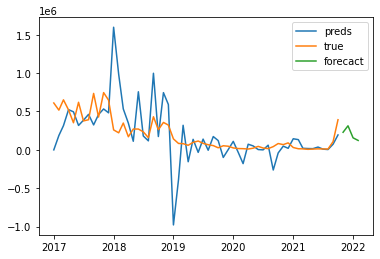

In [404]:
plt.plot(preds)
plt.plot(trend1_1)
plt.plot(forecact)
plt.legend(['preds','true','forecact'])
plt.show()

In [418]:
pdq = parameters_for_arima(trend1_1, lags=22, mod=1)
configurations = sarimax_gridsearch(trend1_1, pdq, [(0,0,0,0)])

  0%|          | 0/16 [00:00<?, ?it/s]

In [419]:
configurations

pdq          pdqs          bic
0  (12, 1, 0)  (0, 0, 0, 0)  1302.123100
1  (12, 1, 1)  (0, 0, 0, 0)  1304.264061
2  (12, 1, 2)  (0, 0, 0, 0)  1307.886679
3  (12, 1, 3)  (0, 0, 0, 0)  1311.300665
4   (9, 1, 1)  (0, 0, 0, 0)  1394.677860

In [420]:
model = sm.tsa.statespace.SARIMAX(trend1_1, order=configurations.loc[1,'pdq'], enforce_stationarity=False, enforce_invertibility=False).fit()
preds = model.predict()
forecast = model.forecast('2022-02-01')

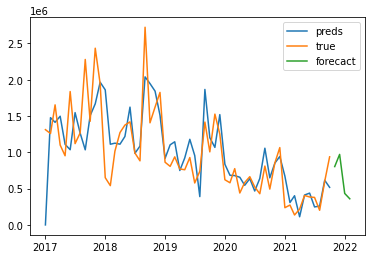

In [421]:
plt.plot(preds)
plt.plot(trend1_1)
plt.plot(forecast)
plt.legend(['preds','true','forecact'])
plt.show()

In [422]:
serie = pd.concat([trend1_1, forecast])

coefs_for_next_observs - отношение i+1 наблюдения к i в получившемся 'общем тренде'
<br/>Это нужно для того, чтобы понимать как следовать тренду для всех товаров, начиная с любой даты мы можем следуя коэфициентам дойти до конца

In [423]:
a = [1]+[serie[i+1]/serie[i] for i in range(0, len(serie)-1)]
coefs_for_next_observs = pd.Series(data=a, index = serie.index)

In [424]:
coefs_for_next_observs.head()

2017-01-01    1.000000
2017-02-01    0.959073
2017-03-01    1.314010
2017-04-01    0.665135
2017-05-01    0.865960
dtype: float64

In [388]:
extra = ["_11_2021", "_12_2021", "_1_2022", "_2_2022"]
columns=["Item_ID", "Target"]
lst=[]
for sku_name in test.sku_name.unique():
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]!=0:
        obs = temp['sellin']
        ds = temp['ds'].values.astype('datetime64[M]')
        ts = make_ts(obs, ds, method = 'linear')
        last_ts_date = max(ts.index).asm8.astype('datetime64[M]')
        cumulative_coefs = np.cumprod(coefs_for_next_observs[last_ts_date+1:])
        for i in range(4):
            pred = ts[last_ts_date]*cumulative_coefs[-4+i]
            lst.append([sku_name + extra[i], pred])
    else:
        for i in range(4):
            lst.append([sku_name + extra[i], 30000])
sub = pd.DataFrame(data=lst, columns = columns)

In [389]:
sub

Item_ID         Target
0     YOSHTLYNYOSHZZ_11_2021  135048.002944
1     YOSHTLYNYOSHZZ_12_2021  150782.835014
2      YOSHTLYNYOSHZZ_1_2022  154327.548200
3      YOSHTLYNYOSHZZ_2_2022  152568.266224
4       YOSHRENECARL_11_2021  239060.129436
...                      ...            ...
1523    ABEENNEARMAZZ_2_2022  143091.976397
1524     ABEAHAMASHL_11_2021   15098.534491
1525     ABEAHAMASHL_12_2021   16857.708262
1526      ABEAHAMASHL_1_2022   17254.011600
1527      ABEAHAMASHL_2_2022   17057.321690

[1528 rows x 2 columns]

In [391]:
sub.to_csv(os.getcwd()+'\submission 45 (general trend by mean, sarima, n_rows 25).csv',index=False)